In [2]:
import subprocess
subprocess.check_output(["pip", "install", "nltk"])

subprocess.check_output(["python", "-m", "nltk.downloader", "all"])

b''

In [3]:
%pylab inline
import msgpack
import nltk
import sklearn.cluster
import message
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import time
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [4]:
with open("/home/jovyan/ymslanda/supportnlp/tickets/all_tickets_and_comments.msgpack", "rb") as f:
    data = msgpack.load(f, raw=False)

with open("stopwords.msgpack", "rb") as f:
    stop_words = msgpack.load(f)
stop_words = set(stop_words).union(stopwords.words('english')).union(stopwords.words('norwegian'))

In [6]:
msgfreq = {}
for org in data.values():
    for ticket in org.values():
        for word in message.message(ticket["description"] + "  " + ticket["subject"], stopwords).dict:
            if word not in msgfreq: msgfreq[word] = 0
            msgfreq[word] += 1

In [7]:
orderedmsgfreq = sorted((freq, word) for (word, freq) in msgfreq.items())

In [17]:
msgs = []
for orgid, org in data.items():
    for ticketid, ticket in org.items():
        m = message.message(ticket["description"] + "  " + ticket["subject"], stopwords)
        m.orgid = orgid
        m.ticketid = ticketid
        msgs.append(m)

## Possible distance measure between tickets for use in clustering
Currently not used :(

In [26]:
conn = np.zeros((len(msgs), len(msgs)))
for ai, a in enumerate(msgs):
    for bi, b in enumerate(msgs):
        conn[ai,bi] = len(a.dict.intersection(b.dict)) / len(a.dict.union(b.dict))

ticketids = np.array(list(msg.ticketid for msg in msgs), dtype="i")

np.savez_compressed("connectivity_iou_description_subject.npz", ticketids=ticketids, conn=conn)

## Cluster tickets

In [158]:

def tickets():
    for org in data.values():
        for ticket in org.values():
            if ticket["subject"] in ("SQLdump",):
                continue
            if len(ticket["description"]) > 10000:
                continue
            yield ticket

tickets = list(tickets())
tickettexts = [re.sub("(\\w)://(\\w)", "\\1URL\\2",
                      re.sub("(\\w):(\\w)", "\\1COLON\\2",
                             re.sub("(\\w)/(\\w)", "\\1SLASH\\2",
                                    re.sub("(\\w)\\.(\\w)", "\\1DOT\\2",
                                         ("%(subject)s %(description)s" % ticket)))))
              for ticket in tickets]

In [214]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words=stop_words)
X = vectorizer.fit_transform(tickettexts)

n_clusters = 100
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=1,
            verbose=True)
    
print("Clustering sparse data with %s" % km)
t0 = time.time()
km.fit(X)
print("done in %0.3fs" % (time.time() - t0))
print()


#print("Top terms per cluster:")
#
#order_centroids = km.cluster_centers_.argsort()[:, ::-1]
#
#terms = vectorizer.get_feature_names()
#for i in range(n_clusters):
#    print("Cluster %d:" % i, end='')
#    for ind in order_centroids[i, :10]:
#        print(' %s' % terms[ind], end='')
#    print()


Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=100, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
Iteration  0, inertia 2858.093
Iteration  1, inertia 1662.802
Iteration  2, inertia 1637.782
Iteration  3, inertia 1625.238
Iteration  4, inertia 1617.978
Iteration  5, inertia 1613.457
Iteration  6, inertia 1611.340
Iteration  7, inertia 1610.060
Iteration  8, inertia 1609.444
Iteration  9, inertia 1609.368
Iteration 10, inertia 1609.335
Iteration 11, inertia 1609.303
Converged at iteration 11: center shift 0.000000e+00 within tolerance 3.409213e-09
done in 7.457s



In [162]:
clustering = km.predict(X)

In [163]:
clusterorder, clustercount = np.unique(clustering, return_counts=True)
srt = clustercount.argsort()
clusterorder = clusterorder[srt]
clustercount = clustercount[srt]

In [ ]:
clusteredtickets = {}
for idx, ticket in enumerate(tickets):
    if clustering[idx] not in clusteredtickets:
        clusteredtickets[clustering[idx]] = []
    clusteredtickets[clustering[idx]].append(ticket)


## Some measures across all tickets

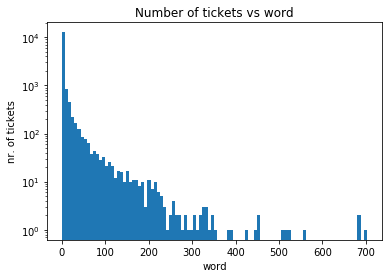

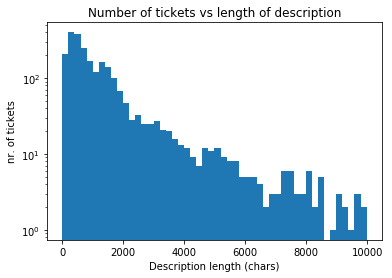

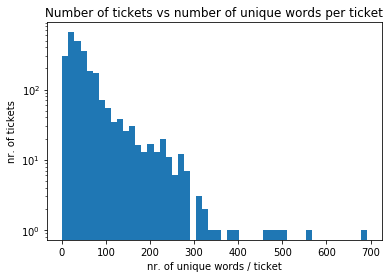

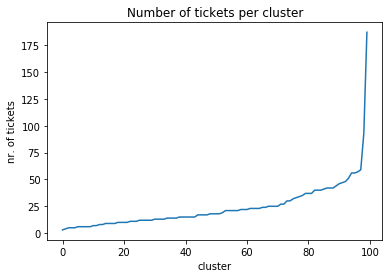

In [211]:
plt.hist(msgfreq.values(), log=True, bins=100)
plt.title("Number of tickets vs word")
plt.xlabel("word")
plt.ylabel("nr. of tickets")
plt.show()

plt.hist([len(ticket["description"]) for ticket in tickets], log=True, bins=50)
plt.title("Number of tickets vs length of description")
plt.xlabel("Description length (chars)")
plt.ylabel("nr. of tickets")
plt.show()

plt.hist([len(msg.dict) for msg in msgs], log=True, bins=50)
plt.title("Number of tickets vs number of unique words per ticket")
plt.xlabel("nr. of unique words / ticket")
plt.ylabel("nr. of tickets")
plt.show()

plt.plot(clustercount)
plt.title("Number of tickets per cluster")
plt.xlabel("cluster")
plt.ylabel("nr. of tickets")
plt.show()

## Cluster example messages (subject lines)

In [197]:
for clusterid in idx[(cnt > 25) & (cnt < 70)]:
    print("Cluster %s" % clusterid)
    for t in clusteredtickets[clusterid][:10]:
        print("    %(subject)s" % t)

Cluster 70
    New request created with ID: ##8810## from Medi Lausanne
    CIELO DI CARTAGENA / NEW CREW REGISTRATION TO DUALOG
    Alpine Hibiscus - Email Address Crew Members
    HIGH STRENGTH : Crew ID and password
    Medi Lausanne - e-Mail account for 3/E Vallega Vincent Caluban
    HIGH STRENGTH : Crew ID and password
    Alpine Maria / V 39 /RESETTING PASSWORD
    Alpine Mary - Crew E-mail account
    Maersk Mizushima: Request password reset for Crew Email ID
    Alpine Hibiscus - Internet access fof supperintendent Sonsun Jacob
Cluster 32
    Re:##28825## : NIGHTHAWK - 20181023 - Re: ##28835## : MV Night Hawk : Dualog functionality issue Onboard
    Fwd:##32308## : RE: ##32308## : MV Thrasher-personal email problem
    RE: MV STELLAR EAGLE / SARTs batteries & VDR beacon / BUSAN
    URGENT - Dualog connection error - Nighthawk
    Re:##30934## : STONINGTON EAGLE - MMan Gitsa Oleksandr // e-mail box issue
    [EXT] [Dualog] Re: URGENT - Dualog connection error - Nighthawk
    Re

## Most common words in descriptions

In [212]:
for f, word in orderedmsgfreq[-10:]:
    print(word, f)

crew 449
bridge 451
captain 455
vsat 509
mobile 516
http 526
phone 556
fax 682
fbb 686
tel 702
